In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io

## Creating the dataset

In [2]:

def load_svhn(path):
    
    matfile = scipy.io.loadmat(path)
    images = matfile['X']
    images = np.expand_dims(images,0)
    images = np.swapaxes(images, 0,4)
    images = np.squeeze(images)
    labels = matfile['y']
    labels = np.squeeze(labels)
    print(len(labels))
    
    validation_images = images[:10000,:,:,:]
    training_images = images[10000:,:,:,:]
    validation_labels = labels[:10000]
    training_labels = labels[10000:]
    
    return training_images, training_labels, validation_images, validation_labels


training_images, training_labels, validation_images, validation_labels = load_svhn('./train_32x32.mat')


73257


## investigating the data

2
1
3
8
10
1
6
5
1
3


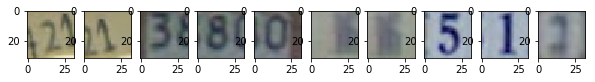

In [3]:
# displaying the first 10 training examples and labels
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10): 
    ax[i].imshow(training_images[i])
    print(training_labels[i])

## Making the datasets

In [4]:
#standardized_images = tf.map_fn(lambda image:tf.image.per_image_standardization(image),training_images)
# create the tensorflow dataset
training_dataset = tf.data.Dataset.from_tensor_slices((training_images, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

# define the batch size
training_batchsize = 200
validation_batchsize = 10000

# split the dataset into batches
training_dataset = training_dataset.batch(training_batchsize)
validation_dataset = validation_dataset.batch(validation_batchsize)

# shuffel the data (in each epoch)
training_dataset = training_dataset.shuffle(buffer_size=4, reshuffle_each_iteration=True)

## Creating an iterator

In [5]:
# create an iterator
iterator = tf.data.Iterator.from_structure(training_dataset.output_types, training_dataset.output_shapes)

# name operation that gives next batch
next_batch = iterator.get_next()

# initializer operations for training and validation dataset
training_initialize_iterator = iterator.make_initializer(training_dataset)
validation_initialize_iterator = iterator.make_initializer(validation_dataset)

# Building the model

## Formarting the data


In [6]:
#get the batch 
input_data = next_batch[0]
input_data = tf.cast(input_data, tf.float32)
labels = next_batch[1]

#make a one hot vector out of labels
labels = tf.cast(labels, tf.int32)
one_hot_labels = tf.one_hot(labels, 10)

## applying convolutional layers

In [7]:
## 1. convolutional layer 1
with tf.variable_scope("conv_layer1"):
    kernel_size = 5
    kernel_number = 16
    channels = 3
    stride = 1
    padding = 'SAME'
    activation_function = tf.tanh
    kernels = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, channels, kernel_number], stddev=0.1))  
    biases = tf.Variable(tf.zeros([kernel_number]))
    convolution = tf.nn.conv2d(input_data, kernels, strides=[1, stride, stride, 1], padding=padding)
    feature_maps1 = activation_function(convolution + biases)
    
with tf.variable_scope("pool_layer1"):
    kernel_size = 2
    stride = 2
    padding = 'SAME'
    pooling1 = tf.nn.max_pool(feature_maps1, ksize=[1, kernel_size, kernel_size, 1], strides=[1, stride, stride, 1], padding=padding)
    
with tf.variable_scope("conv_layer2"):
    kernel_size = 7
    kernel_number = 100
    channels = 16
    stride = 1
    padding = 'SAME'
    activation_function = tf.tanh
    kernels = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, channels, kernel_number], stddev=0.1))  
    biases = tf.Variable(tf.zeros([kernel_number]))
    convolution = tf.nn.conv2d(pooling1, kernels, strides=[1, stride, stride, 1], padding=padding)
    feature_maps2 = activation_function(convolution + biases)
    
with tf.variable_scope("pool_layer2"):
    kernel_size = 2
    stride = 2
    padding = 'SAME'
    pooling2 = tf.nn.max_pool(feature_maps2, ksize=[1, kernel_size, kernel_size, 1], strides=[1, stride, stride, 1], padding=padding)

In [8]:
with tf.variable_scope("fully1"):
    flat_input = tf.layers.Flatten()(pooling2)
    old_neuron_number = int(flat_input.shape[1])
    neuron_number = 512
    activation_function = tf.tanh
    stddev = 1/tf.sqrt(float(old_neuron_number))
    
    rands = tf.truncated_normal([old_neuron_number, neuron_number], stddev=stddev)
    weights = tf.Variable(rands, dtype=tf.float32)
    biases = tf.Variable(tf.zeros(neuron_number), dtype=tf.float32)

    # Now we will mutiply the input with the weights to get the drive 
    drive = flat_input @ weights + biases

    # And use the activation function
    output = activation_function(drive)

In [9]:
# Apply the output layer
with tf.variable_scope("output"):
    flat_input = output
    old_neuron_number = int(flat_input.shape[1])
    neuron_number = 10
    activation_function = tf.nn.softmax
    stddev = 1/tf.sqrt(float(old_neuron_number))
    
    rands = tf.truncated_normal([old_neuron_number, neuron_number], stddev=stddev)
    weights = tf.Variable(rands, dtype=tf.float32)
    biases = tf.Variable(tf.zeros(neuron_number), dtype=tf.float32)

    # Now we will mutiply the input with the weights to get the drive (logits)
    logits = flat_input @ weights + biases

    # And use the softmax activation function
    prediction = activation_function(logits)

In [10]:
#getting loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=logits)
loss = tf.reduce_mean(cross_entropy)

# Define the accuracy
match_bools = tf.equal(labels, tf.cast(tf.argmax(prediction, axis=1), tf.int32))
accuracy = tf.reduce_mean(tf.cast(match_bools, tf.float32))

In [12]:
# First we need to specify a learning rate 
learning_rate = 1e-4
# Then we create an optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# And tell the optimizer that it should minimize the loss
training_step = optimizer.minimize(loss)

In [13]:
# In the end we will specify some summaries, so that we can visualize our progress with tensorboard

# Specify the variables for the summaries
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)

# Now we will merge our two summary scalars
merged_summaries = tf.summary.merge_all()

# We also have two specify two summary file writers 
train_writer = tf.summary.FileWriter('./summaries/train/')
validation_writer = tf.summary.FileWriter('./summaries/validation/', flush_secs=1)

In [14]:
#defining the epochs
epochs = 5
#starting Tensorflow session
with tf.Session() as sess:
    #inizializing variables
    sess.run(tf.global_variables_initializer())
    #making global step counter
    global_step = 0
    #defining the epoch loop (runs through training and validation epoch number of times)
    for _ in range(epochs):
        #initializing iterator with training data for this epoch
        sess.run(training_initialize_iterator)
        #going through all batches once
        while True:
            try:
                #running training step and reading out summary
                _, summary  = sess.run((training_step, merged_summaries))
                #saving the summary
                train_writer.add_summary(summary, global_step)
                #incrementing global step
                global_step = global_step + 1
            except tf.errors.OutOfRangeError:
                break
        
        #Validation part
        #initializing the iterator
        sess.run(validation_initialize_iterator)
        #reading out summary
        summary = sess.run((merged_summaries))
        #saving summary
        validation_writer.add_summary(summary, global_step)